In [1]:
import torch

print(torch.__version__)
print(torch.cuda.is_available())

2.8.0+cu129
True


<br>

## Define Transforms --> resize, normalize

In [2]:
from torchvision import  transforms
 
"""
 with transforms you can resize,normalize images,or create augmented datasets
 here , first I resize images and turn images to torch.Tensor
"""
 
train_transform  = transforms.Compose([
    # Resize Image
    transforms.Resize(size=(180, 180)),   
    # Turn the image into a torch.Tensor , it transforms the image to a tensor with range [0,1]. I t implies some kind of normalization
    transforms.ToTensor()  
])
 
validation_transform  = transforms.Compose([
    transforms.Resize(size=(180, 180)),
    transforms.ToTensor()   
])
 
train_transform,validation_transform

(Compose(
     Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
 ),
 Compose(
     Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
 ))

<br>

### Create Train and Validation Sets

In [3]:
# Use ImageFolder to create datasets
from torchvision import datasets
 
train_dir= r"fish_dataset\train" # path to the train folder
validation_dir= r"fish_dataset\validation" # path to the validation folder
 
train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=train_transform) 
 
validation_data = datasets.ImageFolder(root=validation_dir, 
                                 transform=validation_transform)
 
print(f"Train data:\n{train_data}\n\nValidation data:\n{validation_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 6909
    Root location: fish_dataset\train
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

Validation data:
Dataset ImageFolder
    Number of datapoints: 3309
    Root location: fish_dataset\validation
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


<br>

### Create Dataloader objects

In [ ]:
from torch.utils.data import DataLoader
 
# I created  train_data and validation_data with datasets.ImageFolder 
train_set = DataLoader(dataset=train_data, 
                              batch_size=16, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?
 
validation_set = DataLoader(dataset=validation_data, 
                             batch_size=16, 
                             num_workers=1, 
                             shuffle=False) # dont usually need to shuffle testing data
 
train_set,validation_set

(<torch.utils.data.dataloader.DataLoader at 0x24d17b76c50>,
 <torch.utils.data.dataloader.DataLoader at 0x24d6d7c1d20>)

<br>

### Display Random Examples from Dataset

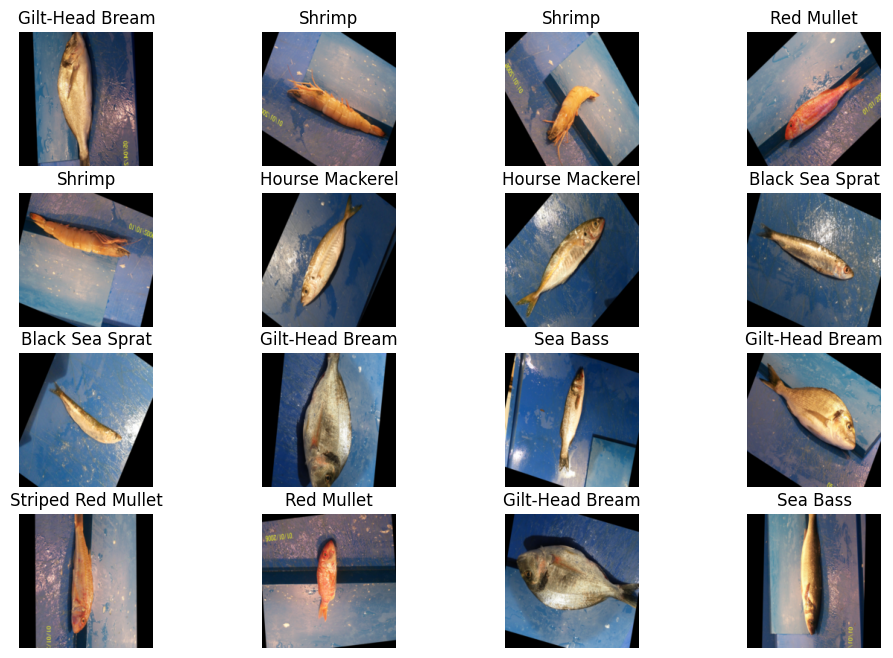

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision.transforms.functional import to_pil_image
 
# I create train_data above , and I will use it here 
label_dict = {y: x for x, y in train_data.class_to_idx.items()}
 
# Define a function to display images
def show_images(images, labels):
    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)
        image = to_pil_image(images[i])  # Convert tensor to PIL Image
        plt.imshow(image)
        plt.title(label_dict[labels[i].item()])  # Convert numerical label to string label
        plt.axis('off')
    plt.show()
 
# Get the first batch
for batch_idx, (images, labels) in enumerate(train_set):
    if batch_idx == 1:  # Only process the first batch
        show_images(images, labels)
        break

<br>

### Class Distribution

In [ ]:
import os

# path to train and validation sets
train_dir = train_dir
validation_dir = validation_dir
 
# calculate distributions in train set and save them to dictionary
train_class_counts = {}
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        train_class_counts[class_folder] = num_images
 
# calculate distributions in validation set and save them to dictionary
validation_class_counts = {}
for class_folder in os.listdir(validation_dir):
    class_path = os.path.join(validation_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        validation_class_counts[class_folder] = num_images

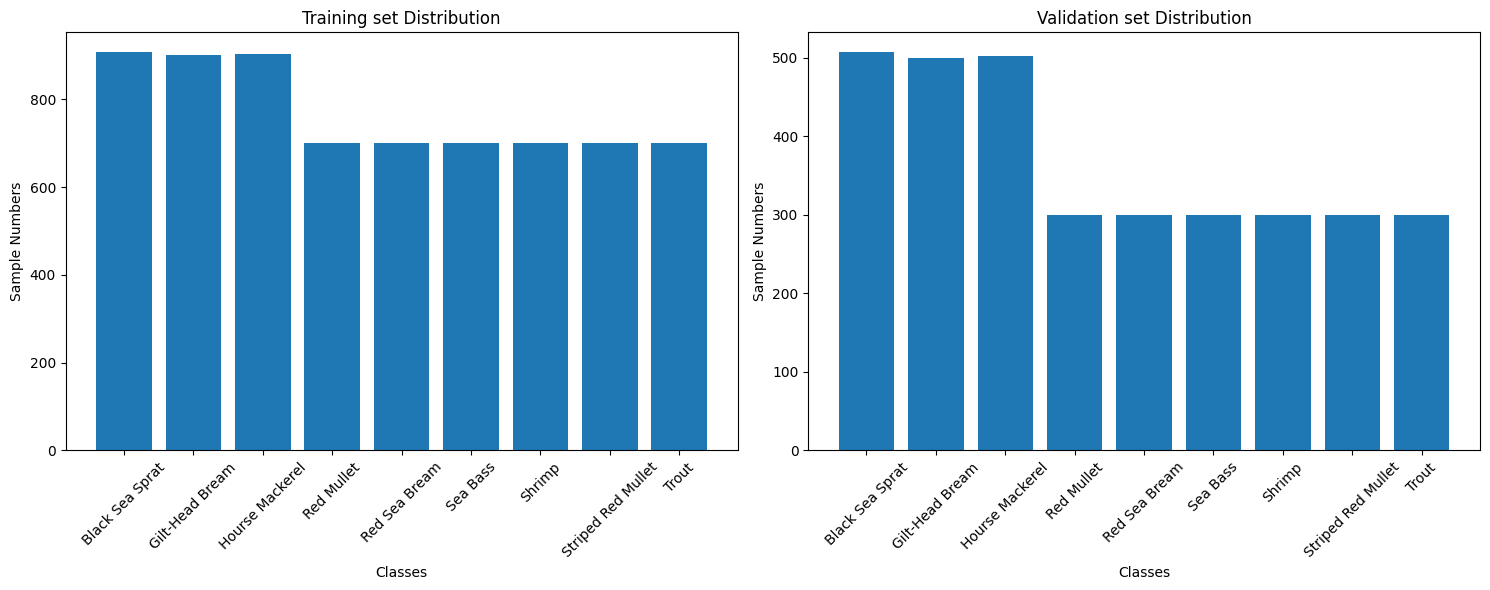

In [8]:
import matplotlib.pyplot as plt
 
plt.figure(figsize=(15, 6))
 
# plot for train set
plt.subplot(1, 2, 1)
plt.bar(train_class_counts.keys(), train_class_counts.values())
plt.title('Training set Distribution')
plt.xlabel('Classes')
plt.ylabel('Sample Numbers')
plt.xticks(rotation=45)
 
# plot for validations set
plt.subplot(1, 2, 2)
plt.bar(validation_class_counts.keys(), validation_class_counts.values())
plt.title('Validation set Distribution')
plt.xlabel('Classes')
plt.ylabel('Sample Numbers')
plt.xticks(rotation=45)
 
plt.tight_layout()
plt.show()

<br><br>

## Training

In [9]:
# create device object
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
# add accuracy values to the list 
train_accuracies=[]
validation_accuracies=[]
 
# Function for training
def train(dataloader, model, loss_fn, optimizer, epoch):
     
    size = len(dataloader.dataset) # total number of images inside of loader
    num_batches = len(dataloader) # number of batches
     
    model.train()
 
    train_loss, correct = 0, 0
     
 
    for batch, (X, y) in enumerate(dataloader):
        
        # move X and y to GPU for faster training
        X, y = X.to(device), y.to(device) 
 
        # make prediction 
        pred = model(X)
        # calculate loss 
        loss = loss_fn(pred, y)
 
        # Backpropagation
        loss.backward() # compute parameters gradients
        optimizer.step() # update parameters
        optimizer.zero_grad() #  reset the gradients of all parameters
 
        # Update training loss
        train_loss += loss.item() # item() method extracts the loss’s value as a Python float
 
        # Calculate training accuracy
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
     
    # loss and accuracy
    train_loss = train_loss / num_batches
    accuracy = 100 * correct / size
     
    # use this accuracy list for plotting accuracy with matplotlib
    train_accuracies.append(accuracy)
 
    # Print training accuracy and loss at the end of epoch
    print(f" Training Accuracy: {accuracy:.2f}%, Training Loss: {train_loss:.4f}")

In [12]:
# function for validation 
def validation(dataloader, model, loss_fn,t):
     
    size = len(dataloader.dataset) # total number of images inside of loader
    num_batches = len(dataloader) # number of batches
     
    validation_loss, correct = 0, 0
     
    # sets the PyTorch model to evaluation mode, it will disable dropout layer
    model.eval()
     
    with torch.no_grad(): #  disable gradient calculation
        for X, y in dataloader:
             
            # move X and y to GPU for faster training
            X, y = X.to(device), y.to(device)
            pred = model(X) # make prediction
            validation_loss += loss_fn(pred, y).item() 
             
            # if prediction is correct add 1 to correct variable.
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
     
    # loss and accuracy
    validation_loss /= num_batches
    accuracy = 100 * correct / size
 
    validation_accuracies.append(accuracy)
 
    # Print test accuracy and loss at the end of epoch
    print(f" Validation Accuracy: {accuracy:.2f}%, Validation Loss: {validation_loss:.4f}")

In [13]:
import torch
# if GPU is available , use it while training 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
import torch
import torch.nn as nn
 
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(SimpleCNN, self).__init__()
         
        # image size is --> (3,180,180) 
         
        # convolutional layer with 32 filter, input dimension is 3 because image has 3 channels
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) 
        # activation function , it introduces to the model , and non-linearity helps to model to learn complex functions .
        self.act1 = nn.ReLU() 
        # MaxPool2d reduces size (90,90)
        self.pool1 = nn.MaxPool2d(2)
         
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)  # --> (45,45)
         
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2) # --> (22,22)
         
        # first flatten the channels and then feed them into the fully connected layer. Given the input shape of (128, 22, 22), flattening it results in 128 * 22 * 22.
        self.fc1 = nn.Linear(128 * 22 * 22 , 256)  
        self.act4 = nn.ReLU()
         
        # dropout drops weights randomly, and here %20 of weights are dropped randomly. It helps to prevent overfitting.
        self.dropout=nn.Dropout(p=0.2) 
         
        # The nn.Linear layer with input size 256 and output size 9 represents the output layer of our neural network. 
        # Since we have 9 classes, the output of this layer will be passed through a softmax activation function.
        # (error function  internally applies softmax activation ,you dont need to add it to here)
        # This converts the raw outputs into probabilities, representing the likelihood of each class. 
        # These probabilities are then used to calculate the error during training
        self.fc2 = nn.Linear(256, 9) 
 
 
    def forward(self, x):
         
        # add outputs on top of each layer and return out in the end
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = self.pool3(self.act3(self.conv3(out)))
         
        out = out.view(out.size(0), -1)
         
        out = self.act4(self.fc1(out))
        out=self.dropout(out)
        out=self.fc2(out)
         
        return out
 
# create the model
model = SimpleCNN()
model.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=61952, out_features=256, bias=True)
  (act4): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=9, bias=True)
)

In [ ]:
# Loss funciton and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-3 ) 

In [16]:
# epoch number 
epochs = 32
 
# loop for training model 
for t in range(epochs):
    print(f"Epoch {t+1}")
    train(train_set, model, loss_fn, optimizer,t) 
    validation(validation_set, model, loss_fn,t)
    print("----------------------------")
print("Done!")

Epoch 1
 Training Accuracy: 13.50%, Training Loss: 2.1900
 Validation Accuracy: 15.41%, Validation Loss: 2.1726
----------------------------
Epoch 2
 Training Accuracy: 15.43%, Training Loss: 2.1786
 Validation Accuracy: 18.53%, Validation Loss: 2.1586
----------------------------
Epoch 3
 Training Accuracy: 20.16%, Training Loss: 2.1621
 Validation Accuracy: 22.33%, Validation Loss: 2.1302
----------------------------
Epoch 4
 Training Accuracy: 23.75%, Training Loss: 2.1233
 Validation Accuracy: 32.15%, Validation Loss: 2.0674
----------------------------
Epoch 5
 Training Accuracy: 30.42%, Training Loss: 1.9992
 Validation Accuracy: 40.44%, Validation Loss: 1.8649
----------------------------
Epoch 6
 Training Accuracy: 35.21%, Training Loss: 1.7948
 Validation Accuracy: 42.10%, Validation Loss: 1.6721
----------------------------
Epoch 7
 Training Accuracy: 41.18%, Training Loss: 1.6554
 Validation Accuracy: 46.84%, Validation Loss: 1.5302
----------------------------
Epoch 8
 Trai

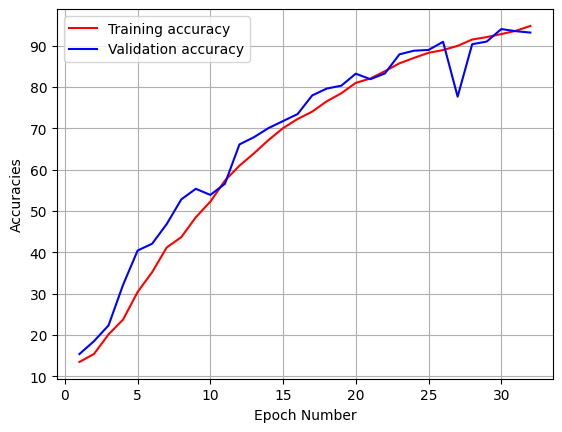

In [35]:
import matplotlib.pyplot as plt 
 
def visualize(train_accuracies,validation_accuracies):
    epoch_number=len(train_accuracies)
 
    plt.plot(range(1,epoch_number+1),train_accuracies,'r', label='Training accuracy')
    plt.plot(range(1,epoch_number+1),validation_accuracies,'b', label='Validation accuracy')
    plt.legend()
    plt.xlabel("Epoch Number")
    plt.ylabel("Accuracies")
    plt.grid()
 
 
# Remember, train_accuracies and validation_accuracies are lists, they stored accuracy values while training
visualize(train_accuracies,validation_accuracies)

<br><br><br>

### Save the model

In [36]:
# save model
torch.save(model.state_dict(), "model.pth")


In [37]:
label_list= os.listdir("fish_dataset/train")
print(label_list)

['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']


<br>

### Test Model

Shrimp


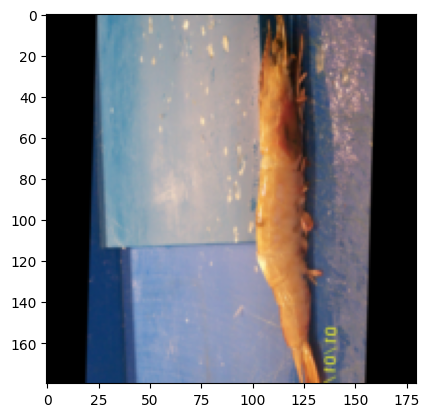

In [38]:
# Make prediction on single image
from PIL import Image
import torchvision.transforms as transforms


# load model and make predictions
model = SimpleCNN()
model.load_state_dict(torch.load("model.pth"))
model.eval()

# Load and preprocess the image
image = Image.open("shrimp.png")
transform = transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.ToTensor(),
])
image = transform(image).unsqueeze(0)  # Add batch dimension

# make prediction and print label using label_list
with torch.no_grad():
    output = model(image)
    _, pred = torch.max(output, 1)
    print(label_list[pred.item()])

plt.imshow(image.squeeze(0).permute(1, 2, 0))

<br><br><br><br>